In [283]:
import pandas as pd
import numpy as np
import missingno as msno
from sklearn import linear_model
from scipy import signal

import dash
dash.__version__
from dash import dcc
from dash import html
from dash.dependencies import Input, Output,State

import plotly.graph_objects as go

# Data Preparation

In [284]:
url = '../data/raw/owid_full_data.csv'
df = pd.read_csv(url, sep=';')

#Get Important Cols out of full data set and sort by date
df_reduced_raw = df[['date', 'location', 'total_cases']].sort_values('date',ascending=True).reset_index(drop=True).copy()

#rename columns
df_reduced = df_reduced_raw.rename(columns= {
  'location':'country',
  'total_cases':'confirmed'
})

df_reduced

,date,country,confirmed
0,2020-01-01,Argentina,NaN
1,2020-01-01,Mexico,NaN
2,2020-01-02,Argentina,NaN
3,2020-01-02,Mexico,NaN
4,2020-01-03,Argentina,NaN
...,...,...,...
203562,2022-07-24,Saint Kitts and Nevis,6422.0
203563,2022-07-24,Ukraine,5291779.0
203564,2022-07-24,Nepal,983622.0
203565,2022-07-24,Central African Republic,14712.0


<AxesSubplot:>

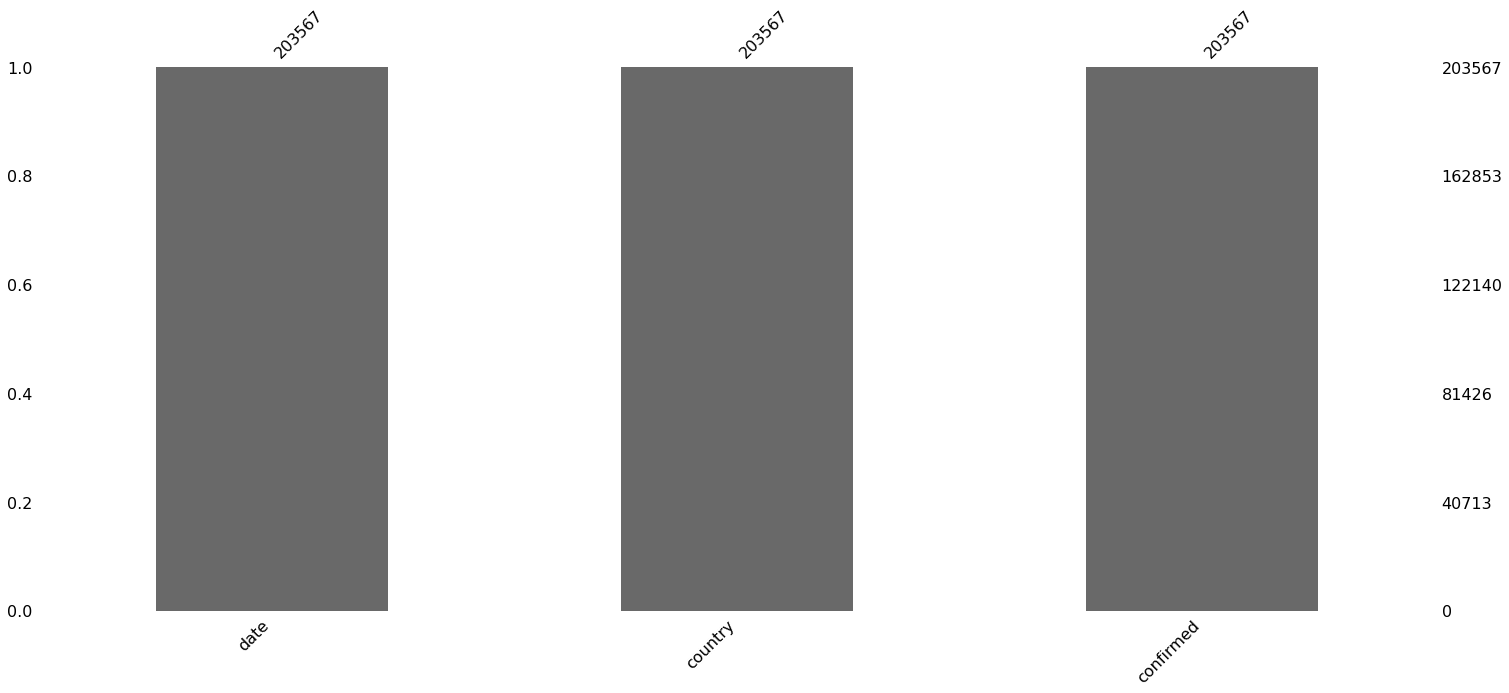

In [285]:
#Fill missing values
df_reduced['confirmed']=df_reduced['confirmed'].fillna(0)

#quick Check if Dataset is complete
msno.bar(df_reduced[['date', 'country', 'confirmed']])

### Doubling Rate

In [286]:
#Functions
def get_doubling_time_via_regression(in_array):
    ''' Use a linear regression to approximate the doubling rate'''

    y = np.array(in_array)
    X = np.arange(-1,2).reshape(-1, 1)

    assert len(in_array)==3
    reg.fit(X,y)
    intercept=reg.intercept_
    slope=reg.coef_

    return intercept/slope

def rolling_reg(df_input,col='confirmed'):
    ''' input has to be a data frame'''
    ''' return is single series (mandatory for group by apply)'''
    days_back=3
    result=df_input[col].rolling(
                window=days_back,
                min_periods=days_back).apply(get_doubling_time_via_regression,raw=False)
    return result

#### New Data Set only with regression

In [325]:
#test set
df_testing=df_reduced[(df_reduced['country']=='United States')|
                      (df_reduced['country']=='Germany') |
                      (df_reduced['country']=='Israel') |
                      (df_reduced['country']=='South Korea') |
                      (df_reduced['country']=='China')
                      ].reset_index(drop=True)

df_testing

,date,country,confirmed
0,2020-01-22,China,547.0
1,2020-01-22,South Korea,1.0
2,2020-01-22,United States,1.0
3,2020-01-23,United States,1.0
4,2020-01-23,China,639.0
...,...,...,...
4536,2022-07-24,South Korea,19247496.0
4537,2022-07-24,Israel,4551137.0
4538,2022-07-24,United States,90410386.0
4539,2022-07-24,Germany,30331133.0


In [326]:
#Group-by -> adding dr to set
df_justDR = df_testing[['country', 'confirmed']].groupby('country').apply(rolling_reg,'confirmed').reset_index()

df_justDR

,country,level_1,confirmed
0,China,0,NaN
1,China,4,NaN
2,China,6,3.797651
3,China,11,2.591228
4,China,12,2.546248
...,...,...,...
4536,United States,4518,538.072800
4537,United States,4522,486.703188
4538,United States,4527,562.367482
4539,United States,4533,951.996385


In [327]:
#Renaming Columns 
df_justDR = df_justDR.rename(columns={
  'confirmed':'confirmed_DR',
  'level_1':'index'
})

df_justDR

,country,index,confirmed_DR
0,China,0,NaN
1,China,4,NaN
2,China,6,3.797651
3,China,11,2.591228
4,China,12,2.546248
...,...,...,...
4536,United States,4518,538.072800
4537,United States,4522,486.703188
4538,United States,4527,562.367482
4539,United States,4533,951.996385


In [330]:
#joining Data Sets
df_testing = df_testing.reset_index()
df_testing_all = pd.merge(df_testing, df_justDR[['index','confirmed_DR']], on=['index'], how='left')
df_testing_all

,index,date,country,confirmed,confirmed_DR
0,0,2020-01-22,China,547.0,NaN
1,1,2020-01-22,South Korea,1.0,NaN
2,2,2020-01-22,United States,1.0,NaN
3,3,2020-01-23,United States,1.0,NaN
4,4,2020-01-23,China,639.0,NaN
...,...,...,...,...,...
4536,4536,2022-07-24,South Korea,19247496.0,3.790470e+02
4537,4537,2022-07-24,Israel,4551137.0,1.254130e+03
4538,4538,2022-07-24,United States,90410386.0,4.172901e+03
4539,4539,2022-07-24,Germany,30331133.0,3.033113e+07


### Filter Data

In [331]:
#Functions
def savgol_filter(df_input,column='confirmed',window=5):
    ''' Savgol Filter which can be used in groupby apply function 
        it ensures that the data structure is kept'''
    degree=1
    df_result=df_input
    
    filter_in=df_input[column].fillna(0) # attention with the neutral element here
    
    result=signal.savgol_filter(np.array(filter_in),
                           window, # window size used for filtering
                           degree)
    df_result[column+'_filtered']=result
    return df_result

In [332]:
# Reason: Often Mondays more cases due to missing tests on weekend

#FILTER CONFIRMED
df_confirmed_filtered = df_testing[['country','confirmed']].groupby(['country']).apply(savgol_filter).reset_index()

df_confirmed_filtered

,index,country,confirmed,confirmed_filtered
0,0,China,547.0,354.6
1,1,South Korea,1.0,0.8
2,2,United States,1.0,0.4
3,3,United States,1.0,1.3
4,4,China,639.0,733.6
...,...,...,...,...
4536,4536,South Korea,19247496.0,19260562.8
4537,4537,Israel,4551137.0,4552084.6
4538,4538,United States,90410386.0,90466466.2
4539,4539,Germany,30331133.0,30371098.6


In [333]:
#Merge
df_testing_all = pd.merge(df_testing_all, df_confirmed_filtered[['index', 'confirmed_filtered']],on=['index'],how='left') 

df_testing_all

,index,date,country,confirmed,confirmed_DR,confirmed_filtered
0,0,2020-01-22,China,547.0,NaN,354.6
1,1,2020-01-22,South Korea,1.0,NaN,0.8
2,2,2020-01-22,United States,1.0,NaN,0.4
3,3,2020-01-23,United States,1.0,NaN,1.3
4,4,2020-01-23,China,639.0,NaN,733.6
...,...,...,...,...,...,...
4536,4536,2022-07-24,South Korea,19247496.0,3.790470e+02,19260562.8
4537,4537,2022-07-24,Israel,4551137.0,1.254130e+03,4552084.6
4538,4538,2022-07-24,United States,90410386.0,4.172901e+03,90466466.2
4539,4539,2022-07-24,Germany,30331133.0,3.033113e+07,30371098.6


In [334]:
#FILTER DOUBLING RATE
df_dr_filtered = df_testing_all[['country', 'confirmed_filtered']].groupby(['country']).apply(rolling_reg,'confirmed_filtered').reset_index()
#renaming
df_dr_filtered = df_dr_filtered.rename(columns={
                  'confirmed_filtered':'confirmed_filtered_DR',
                  'level_1':'index'
                })

df_dr_filtered

,country,index,confirmed_filtered_DR
0,China,0,NaN
1,China,4,NaN
2,China,6,1.935620
3,China,11,2.708779
4,China,12,2.433505
...,...,...,...
4536,United States,4518,602.759336
4537,United States,4522,601.188637
4538,United States,4527,716.792257
4539,United States,4533,868.956527


In [343]:
#Merge
df_testing_all = pd.merge(df_testing_all, df_dr_filtered[['index', 'confirmed_filtered_DR']],on='index',how='left')

df_testing_all.to_csv('../data/processed/covid_testing_5countries.csv', ';')

df_testing_all

,index,date,country,confirmed,confirmed_DR,confirmed_filtered,confirmed_filtered_DR_x,confirmed_filtered_DR_y
0,0,2020-01-22,China,547.0,NaN,354.6,NaN,NaN
1,1,2020-01-22,South Korea,1.0,NaN,0.8,NaN,NaN
2,2,2020-01-22,United States,1.0,NaN,0.4,NaN,NaN
3,3,2020-01-23,United States,1.0,NaN,1.3,NaN,NaN
4,4,2020-01-23,China,639.0,NaN,733.6,NaN,NaN
...,...,...,...,...,...,...,...,...
4536,4536,2022-07-24,South Korea,19247496.0,3.790470e+02,19260562.8,314.340607,314.340607
4537,4537,2022-07-24,Israel,4551137.0,1.254130e+03,4552084.6,939.163699,939.163699
4538,4538,2022-07-24,United States,90410386.0,4.172901e+03,90466466.2,984.476709,984.476709
4539,4539,2022-07-24,Germany,30331133.0,3.033113e+07,30371098.6,616.711815,616.711815


In [339]:
#Mask 'bad' data

mask=df_testing_all['confirmed']>100
df_testing_all['confirmed_filtered_DR']=df_testing_all['confirmed_filtered_DR'].where(mask, other=np.NaN)

In [340]:
countries = df_testing_all['country'].unique().tolist()
countries

['China', 'South Korea', 'United States', 'Germany', 'Israel']

In [341]:
fig = go.Figure()
app = dash.Dash()
app.layout = html.Div([

    dcc.Markdown('''
    #  Enterise Data Science TUK

    COVID-19 Dashboard

    '''),

    dcc.Markdown('''
    ## Multi-Select Country for visualization
    '''),

    dcc.Dropdown(
        id='country_drop_down',
        options=[ 
            {'label': each,'value':each} for each in countries
        ],
        value=['United States','Germany','Italy'], #pre-selected
        multi=True
    ),

    dcc.Markdown('''
        ## Select Timeline of confirmed COVID-19 cases or the approximated doubling time
        '''),

    dcc.Dropdown(
        id='selected_data_drop_down',
        options=[
            {'label': 'Timeline Confirmed ', 'value': 'confirmed'},
            {'label': 'Timeline Confirmed Filtered', 'value': 'confirmed_filtered'},
            {'label': 'Timeline Confirmed Doubling Rate', 'value': 'confirmed_DR'},
            {'label': 'Timeline Confirmed Doubling Rate Filtered', 'value': 'confirmed_filtered_DR'}
        ],
        value='confirmed',
        multi=False
    ),

    dcc.Graph(figure=fig, id='main_window_slope'),

    dcc.Markdown('''
        ## Select Timeline of confirmed COVID-19 cases or the approximated doubling time
        '''),

    dcc.Dropdown(
        id='y_Axis_scale',
        options=[
            {'label': 'Linear', 'value': 'linear'},
            {'label': 'Logarithmic', 'value': 'log'}
        ],
        value='log',
        multi=False
    )
])



@app.callback(
    Output('main_window_slope', 'figure'),
    [Input('country_drop_down', 'value'), Input('selected_data_drop_down', 'value'), Input('y_Axis_scale', 'value')] #Input Country_list, Selected Data, Axis
)
def update_figure(country_list, selected_data, yAxis):

    my_yaxis={'type': yAxis,
                'title':'Confirmed infected people (source johns hopkins csse)'
                }


    traces = []
    for each in country_list:

        df_plot = df_testing_all[df_testing_all['country']==each]

        traces.append(dict(x=df_plot.date,
                                y=df_plot[selected_data],
                                mode='markers+lines',
                                line_width=1,
                                name=each
                        )
                )
    #Return with Dict with all data
    return {
            'data': traces,
            'layout': dict (
                width=1280,
                height=720,
                xaxis={'title':'Timeline',
                        'tickangle':-45,
                        'nticks':20,
                        'tickfont':dict(size=14,color="#7f7f7f"),
                      },

                yaxis=my_yaxis
        )
    }

In [342]:
app.run_server(debug=True, use_reloader=False)

Dash is running on http://127.0.0.1:8050/

Dash is running on http://127.0.0.1:8050/

Dash is running on http://127.0.0.1:8050/

Dash is running on http://127.0.0.1:8050/

Dash is running on http://127.0.0.1:8050/

Dash is running on http://127.0.0.1:8050/

Dash is running on http://127.0.0.1:8050/

Dash is running on http://127.0.0.1:8050/

Dash is running on http://127.0.0.1:8050/

Dash is running on http://127.0.0.1:8050/

Dash is running on http://127.0.0.1:8050/

Dash is running on http://127.0.0.1:8050/

 * Serving Flask app '__main__' (lazy loading)
 * Environment: production
   Use a production WSGI server instead.
 * Debug mode: on
